# HW 2: Clustering and Topic Models [100 points]

Name: Diksha Boruah

Andrew ID: dboruah

Collaborators (if none, say "none"; do *not* leave this blank): none

Reminder: you should not be sharing code.

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). Data is provided in the `enron` data directory, with one file per email. The data set includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam. 

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [50]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [51]:
########################################################################
######################### Write your code here #########################
########################################################################
import glob
processed_doc_list=[]
for file in glob.glob('./data/enron/*.txt'):
    processed_doc_list.append(make_word_list(file))

### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [52]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer(stop_words='english',min_df=50, max_df=0.8)
X=vectorizer.fit_transform(processed_doc_list).toarray()
#print(vectorizer.vocabulary_)
print(len(vectorizer.vocabulary_))

1680


### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix X using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [53]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.mixture import GaussianMixture
from collections import Counter
n_clusters=3
gmm = GaussianMixture(n_components=n_clusters, random_state=0)
gmm.fit(X)
predicted=gmm.predict(X)


In [55]:
no_of_docs_in_cluster=Counter(predicted)
print(no_of_docs_in_cluster)

Counter({2: 3060, 1: 1748, 0: 363})


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes four parameters:
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [56]:
def plot_spam_words_by_cluster(predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

[238, 1670, 998]


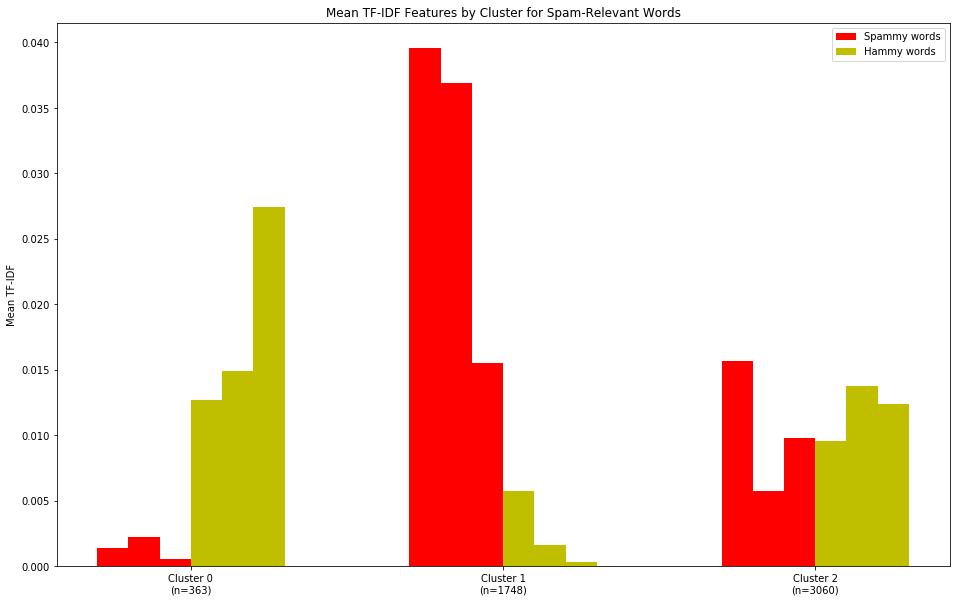

In [57]:
########################################################################
######################### Write your code here #########################
########################################################################
spammy_words = ['click', 'www', 'offer']
hammy_words = ['meeting', 'attached', 'review']
spam_indices=[vectorizer.vocabulary_[word] for word in spammy_words]
ham_indices=[vectorizer.vocabulary_[word] for word in hammy_words]
print(spam_indices)
plot_spam_words_by_cluster(predicted,3,spam_indices,ham_indices)

### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

*** WRITE YOUR ANSWER HERE IN TEXT ***
With n_clusters=3 it seems that cluster 1 has mostly spam words whereas cluster 0 has mostly ham words. But cluster 2 has a mixture of both.
With n_cluster=5 the distinction between spammy and hammy words is a bit more clear. Cluster 2 has mostly spammy words and almost no hammy words. Cluster 3 also has a high amount of spammy words. Cluster 0 and 4 have a higher amount of hammy words than spammy words.
With n_cluster=2, the clusters are a bit less distinct. Although it seems that the amount of spamy words is more in general.
Thus changing the number of cluster to 5 appears better in locating spam emails as compared to 3 clusters.

In [58]:
########################################################################
######################### Write your code here #########################
########################################################################
n_clusters=5
gmm5 = GaussianMixture(n_components=n_clusters, random_state=0)
predicted5=gmm5.fit_predict(X)

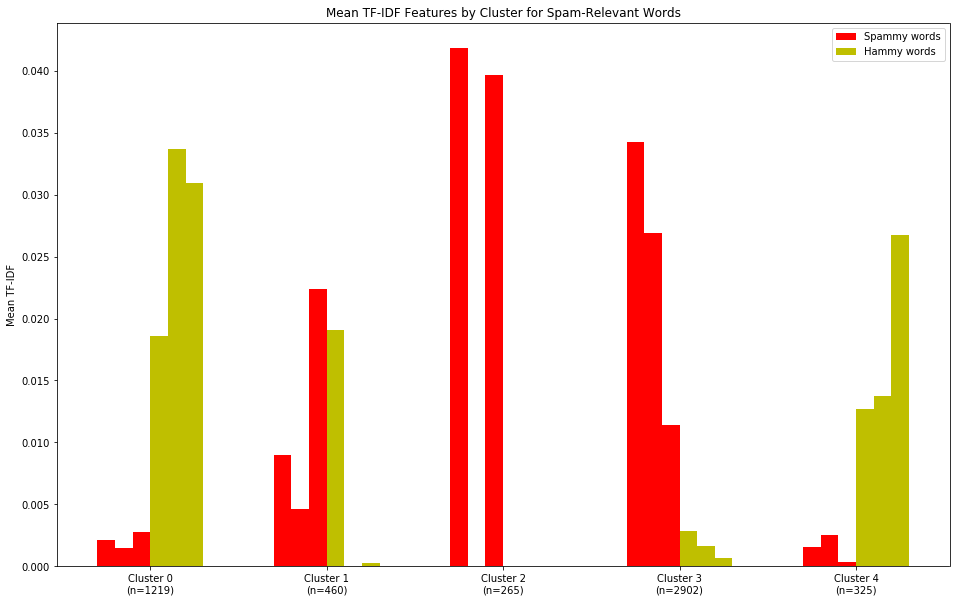

In [59]:
plot_spam_words_by_cluster(predicted5,n_clusters,spam_indices,ham_indices)

In [60]:
n_clusters=2
gmm2 = GaussianMixture(n_components=n_clusters, random_state=0)
predicted2=gmm2.fit_predict(X)

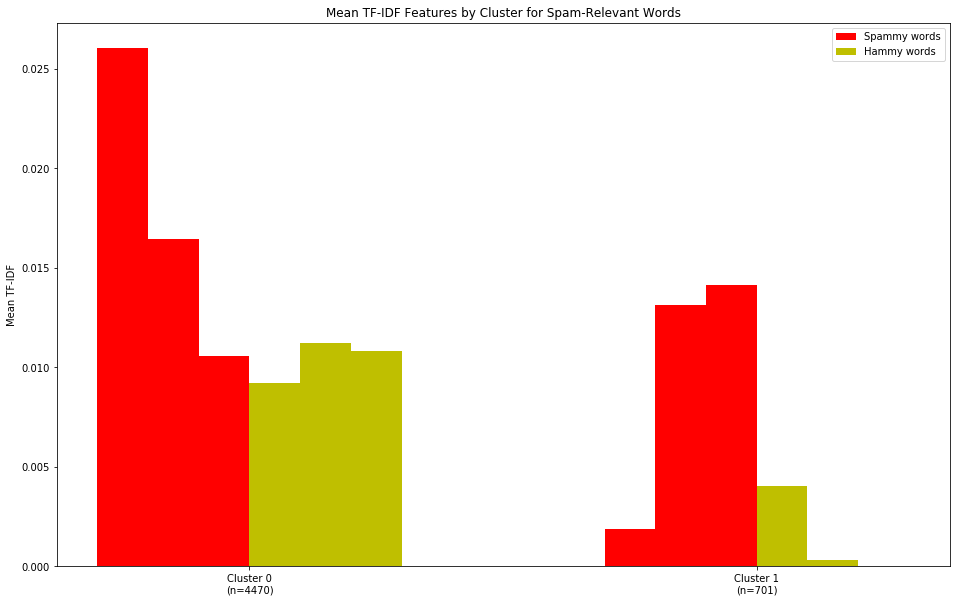

In [61]:
plot_spam_words_by_cluster(predicted2,n_clusters,spam_indices,ham_indices)

## Question 2: Latent "Purposes" in Mobile Apps [45 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [63]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [64]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [65]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [66]:
permission_columns = list(df.columns[10:])#name of the columns after permissions
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]

X = df_perms.as_matrix()
X
#del df # uncomment to free up RAM
#del df_perms # uncomment to free up RAM

C:\Users\diksh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Part C: Downweight "stop-words" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [67]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.feature_extraction.text import TfidfTransformer
normalized_data=TfidfTransformer().fit_transform(X)
print(type(normalized_data))

<class 'scipy.sparse.csr.csr_matrix'>


### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [68]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################
num_topics = 10

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online',n_jobs=-1, random_state=0)
lda.fit(noramlized_data)

Wall time: 3min 59s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [69]:
########################################################################
######################### Write your code here #########################
########################################################################
num_top_words = 10
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])
print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_distributions[topic_idx])
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(df_perms.columns[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
    print()

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
Phone calls : read phone state and identity (D) : 0.5447469988400978
Network communication : view network state (S) : 0.23023273981632986
Network communication : full Internet access (D) : 0.22333735303077876
Default : force application to close (S) : 0.00045120633709505077
Storage : modify/delete USB storage contents modify/delete SD card contents (D) : 7.289192120161884e-06
Development tools : make all background applications close (D) : 7.289126316411403e-06
System tools : prevent device from sleeping (D) : 7.288764513499411e-06
System tools : retrieve running applications (D) : 7.288616769732441e-06
Your location : fine (GPS) location (D) : 7.288520282975203e-06
Default : directly install applications (S) : 7.288481395704183e-06

[Topic 1]
Hardware controls : control vibrator (S) : 0.6987936605017276
Network communication : full Internet access (D) : 0.17521947650475866
Network communicatio

*** WRITE YOUR ANSWER HERE IN TEXT ***<br>
Topic 1: this is  about controlling the phone vibrator<br>
Topic 2: has a high probability of almost 0.7 for obtaining full internet access<br>
Topic 5: seems to be about modifying or deleting USB storage and SD card contents<br>
Topic 8: seems to be about preventing the device from sleeping<br>


### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [70]:
########################################################################
######################### Write your code here #########################
########################################################################
noramlized_data_transform=lda.transform(noramlized_data)

for indx in range(10):
    print('TOPIC',indx)
    max_indx = np.argsort(-noramlized_data_transform[:,indx])
    count=0
    for i in max_indx:
        if(app_ratings[i]>=100000): 
            print(app_names[i])
            count+=1
        if(count==3): # we need top 3 
            break
    print()

TOPIC 0
Blast Monkeys
World Newspapers
Paradise Island

TOPIC 1
Drag Racing
Mouse Trap
Bubble Blast 2

TOPIC 2
Angry Birds Seasons
Yoo Ninja! Free
Adobe Reader

TOPIC 3
Netflix
Advanced Task Killer
Words With Friends Free

TOPIC 4
Restaurant Story™
Restaurant Story???
Gmail

TOPIC 5
SpeechSynthesis Data Installer
Racing Moto
Paradise Island

TOPIC 6
Tiny Flashlight + LED
Toss It
GasBuddy

TOPIC 7
Racing Moto
Dolphin Browser??? HD
Dolphin Browser™ HD

TOPIC 8
Wallpapers HD
Robo Defense FREE
Strip Poker

TOPIC 9
Skype
YouTube
TiKL



### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.206s...
[t-SNE] Computed neighbors for 1200 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.279106
[t-SNE] KL divergence after 1000 iterations: -0.398717
Wall time: 12.6 s


(-288.194396186317, 265.5068693025667, -312.42517564868433, 238.05100981103823)

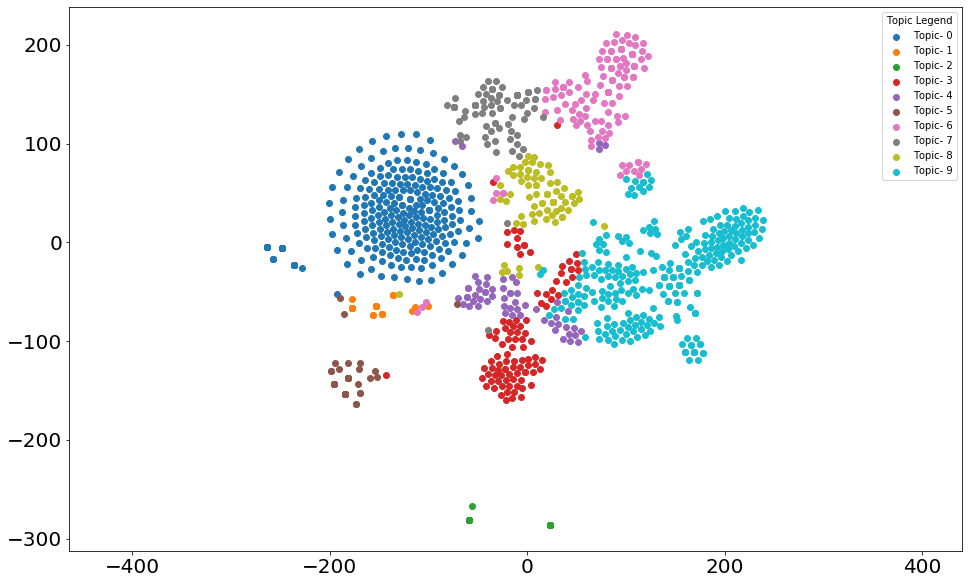

In [71]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', angle=0.5, perplexity = 60, learning_rate=800, verbose=1,random_state=0)

maxvalues=np.argmax(noramlized_data_transform,axis=1)[:1200]
noramlized_data_tsne =tsne.fit_transform(noramlized_data_transform[:1200])

plt.rcParams["figure.figsize"] = (16,10)
for i in range(10):
    plt.scatter(noramlized_data_tsne[maxvalues==i, 0], noramlized_data_tsne[maxvalues==i, 1],label="Topic- "+str(i))
    plt.legend(loc="upper right", title="Topic Legend")
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
plt.axis('equal')

## Question 3: Questionnaire [5 points]

Please answer this survey after you have done this homework: https://forms.gle/rMSREZSd96GbQNoT8